In [2]:
# Figure: Comparing Async LQR and Sync LQR with respect to a wall clock timer

In [3]:
pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 3.4 MB/s eta 0:00:00


In [68]:
import numpy as np
import numpy.random as rnd
import control
from control import dlqr
import matplotlib.pyplot as plt
import time
import random
import gc
from scipy.io import loadmat
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [69]:
def perturbe_matrices(nominal, M, mask, epsilon):

    A = []
    for i in range(M):
        if i == 0:
          noise = 0
        else:
          noise = random.uniform(0, epsilon)

        A.append(nominal + mask*noise)


    return A


def grad_zo(A, B, Q, R, K, r, m):
    nx = A.shape[0]
    nu = B.shape[1]
    K1 = []
    K2 = []
    cost_1 = []
    cost_2 = []
    grad = np.zeros((nu, nx))
    Ul=[]
    for l in range(m):

        U = np.random.randn(B.shape[1], A.shape[0])
        U = (U / np.linalg.norm(U))* r

        K1.append(K + U)
        K2.append(K - U)

        # Compute cost
        x_0 = np.random.normal(0.5, 1e-3, size=(1,nx))[0]
        cost_1.append(lqr_cost(A, B, Q, R, K1[-1], x_0))
        cost_2.append(lqr_cost(A, B, Q, R, K2[-1], x_0))
        Ul.append(U)

    for l in range(m):
        grad += ((nx * nu) / (2 * m * (r ** 2))) * (cost_1[l] - cost_2[l]) * Ul[l]

    return grad


def local_step(K,eta_l,r,m,A,B,Q,R):

    #Estimate the gradient
    grad_estimate = grad_zo(A, B, Q, R, K, r, m)

    #One-step PG
    K_tilde = K - eta_l*grad_estimate


    return K_tilde - K #return model update


def lqr_cost(A, B, Q, R, K, x_0):
        T = 100
        PK = Q.copy()
        for t in range(T + 1):
            PK = Q + K.T @ R @ K + (A - B @ K).T @ PK @ (A - B @ K)
        cost = x_0 @ PK @ x_0
        return cost


def simulate(A, B, K, T, x_0):
        x_t = x0.copy()
        states = [x_t]
        controls = []
        for i in range(T):
            u_t = - K @ x_t
            controls.append(u_t)
            x_t = A @ x_t + B @ u_t
            states.append(x_t)
        return states

$\textbf{System matrices:}$

In [70]:
#Nominal system matrices

A_0 = np.array([[ 1.22,  0.03, -0.02, -0.32],
              [ 0.01,  4.7 ,  0.  ,  0.  ],
              [ 0.02, -0.06,  0.4 ,  0.  ],
              [ 0.01, -0.04,  0.72,  1.55]])

B_0 = np.array([[ 0.01,  0.99],
              [-3.44,  1.66],
              [-0.83,  0.44],
              [-0.47,  0.25]])


#Modification patterns
A_tilde = np.diag([1,2,3,4])
B_tilde = np.ones((4,2))
Q_tilde = np.diag([2,2,2,2])
R_tilde = np.diag([2,2])

nx = A_0.shape[0]
nu = B_0.shape[1]

Q_0 = np.eye(nx)
R_0 = np.eye(nu)

x_0 = np.array([0.25,0.55,0.35,0.45])

#Generate M tuples (Ai,Bi,Qi,Ri) according to the heterogeneity level (eps_A,eps_B,eps_Q,eps_R)

M = 100

epsilon_A = 0.01
A = perturbe_matrices(A_0, M, A_tilde, epsilon_A)

epsilon_B = 0.01
B = perturbe_matrices(B_0, M, B_tilde, epsilon_B)

epsilon_Q = 0.01
Q = perturbe_matrices(Q_0, M, Q_tilde, epsilon_Q)

epsilon_R = 0.01
R = perturbe_matrices(R_0, M, R_tilde, epsilon_R)


#Checking the heterogeneity

norm_1 = []
norm_2 = []
norm_3 = []
norm_4 = []
for p in range(M):
    for s in range(M):
        norm_1.append(np.linalg.norm(A[p] - A[s]))
        norm_2.append(np.linalg.norm(B[p] - B[s]))
        norm_3.append(np.linalg.norm(Q[p] - Q[s]))
        norm_4.append(np.linalg.norm(R[p] - R[s]))

print(["eps_A=", max(norm_1)])
print(["eps_B=", max(norm_2)])
print(["eps_Q=", max(norm_3)])
print(["eps_R=", max(norm_4)])

['eps_A=', 0.05464059176803973]
['eps_B=', 0.02744176655817605]
['eps_Q=', 0.03961294881096311]
['eps_R=', 0.028206856052255248]


$\textbf{Initial Stabilizing Controller:}$

In [71]:
K_opt_nominal,_,_ = dlqr(A_0, B_0, Q_0, R_0)
cost_opt_nominal = lqr_cost(A_0, B_0, Q_0, R_0, K_opt_nominal, x_0)

#Perturbing K_opt_nominal to generate an initial stabilizing controllers for all the M systems

K_0 = np.array([[ 0.33683197, -1.7417071 ,  0.15033713,  0.28966262],
               [ 0.68460759,  0.42031008, -0.28415275, -0.6531542 ]])
cost_init = lqr_cost(A_0, B_0, Q_0, R_0, K_0, x_0)

print(["cost_opt=", cost_opt_nominal])
print(["cost_init=", cost_init])

['cost_opt=', 2.7147945921976557]
['cost_init=', 4.062822450452139]


In [72]:
print(["K0",K_0])

['K0', array([[ 0.33683197, -1.7417071 ,  0.15033713,  0.28966262],
       [ 0.68460759,  0.42031008, -0.28415275, -0.6531542 ]])]


In [73]:
#Checking if K_0 stabilizes all the M systems
flag = 0
for i in range(M):
    if sum([abs_eig > 1 for abs_eig in abs(LA.eigvals(A[i] - B[i]@K_0))]):
        assert False
        flag = 1
if flag == 0:
    print("K0 stabilizes all M systems")

K0 stabilizes all M systems


$\textbf{Asynchronous LQR design:}$

In [96]:
def async_LQR(A,B,Q,R,K_0,eta_l,eta_g,bs,r,m,x_0,stragglers,tau_max,tolerance,M):
    start_time_wc = time.time()
    wall_clock_timer = 1

    #free up memory
    gc.collect()

    gap = []

    #Iteration and buffer counters:

    s = 0
    n = 0



    cost_init = lqr_cost(A[0], B[0], Q[0], R[0], K_0, x_0)
    K_opt_nominal,_,_ = dlqr(A[0], B[0], Q[0], R[0])
    cost_opt_nominal = lqr_cost(A[0], B[0], Q[0], R[0], K_opt_nominal, x_0)
    gap.append(cost_init - cost_opt_nominal)
    print(f"Cost gap: {gap[0]}")



    #Initialize the server
    K = K_0

    #Initialize local controllers
    Ks = []
    for i in range(M):
        Ks.append(K)

    flag_done = np.zeros((M,2))
    Delta = np.zeros((nu,nx))
    Deltas = []


    for i in range(M):
        Deltas.append(local_step(Ks[i],eta_l,r,m,A[i],B[i],Q[i],R[i]))



    indices = []

    #free up memory
    gc.collect()


    #Each system has its own counter

    timer = 1
    timers = []

    for i in range(M):
      timers.append(timer)



    while gap[-1]>tolerance:



        if n%tau_max != 0 :

            Delta = np.zeros((nu,nx))
            s = 0
            for i in range(M):
                if i not in stragglers:
                  Delta += Deltas[i]
                  s += 1
                  if s == bs:
                    break

            #Aggregate:
            K = K + eta_g*(1/bs)*Delta
            cost = lqr_cost(A[0], B[0], Q[0], R[0], K, x_0)
            gap.append(cost - cost_opt_nominal)
            end_time = time.time()
            print(f"Cost gap: {gap[-1]}")




            #Send the new controller to the clients that participate in the update

            for i in range(M):
              if i not in stragglers:

                 Ks[i] = K
                 Deltas[i] = local_step(Ks[i],eta_l,r,m,A[i],B[i],Q[i],R[i])


        else:
            Delta = np.zeros((nu,nx))
            s = 0
            for i in range(len(stragglers)):
                  Delta += Deltas[stragglers[i]]
                  s += 1
            for i in range(M):
                if i not in stragglers:
                  Delta += Deltas[i]
                  s += 1
                  if s == bs:
                    break

            #Aggregate:
            K = K + eta_g*(1/bs)*Delta
            cost = lqr_cost(A[0], B[0], Q[0], R[0], K, x_0)
            gap.append(cost - cost_opt_nominal)
            end_time = time.time()
            print(f"Cost gap: {gap[-1]}")



            #Send the new controller to the clients that participate in the update

            for i in range(len(stragglers)):
                 Ks[stragglers[i]] = K
                 Deltas[stragglers[i]] = local_step(Ks[stragglers[i]],eta_l,r,m,A[stragglers[i]],B[stragglers[i]],Q[stragglers[i]],R[stragglers[i]])

        wall_clock_timer+=1

    end_time_wc = time.time()
    #return end_time_wc - start_time_wc
    return wall_clock_timer

In [95]:
def sync_LQR(A,B,Q,R,K_0,eta_l,eta_g,bs,r,m,x_0,stragglers,tau_max,tolerance,M):

    start_time_wc = time.time()

    wall_clock_timer = 1

    #free up memory
    gc.collect()

    gap = []

    #Iteration and buffer counters:

    s = 0
    n = 0



    cost_init = lqr_cost(A[0], B[0], Q[0], R[0], K_0, x_0)
    K_opt_nominal,_,_ = dlqr(A[0], B[0], Q[0], R[0])
    cost_opt_nominal = lqr_cost(A[0], B[0], Q[0], R[0], K_opt_nominal, x_0)
    gap.append(cost_init - cost_opt_nominal)
    print(f"Cost gap: {gap[0]}")



    #Initialize the server
    K = K_0

    #Initialize local controllers
    Ks = []
    for i in range(M):
        Ks.append(K)

    flag_done = np.zeros((M,2))
    Delta = np.zeros((nu,nx))
    Deltas = []


    for i in range(M):
        Deltas.append(local_step(Ks[i],eta_l,r,m,A[i],B[i],Q[i],R[i]))



    indices = []

    #free up memory
    gc.collect()


    #Each system has its own counter

    timer = 1
    timers = []

    for i in range(M):
      timers.append(timer)



    while gap[-1]>tolerance:

        if wall_clock_timer%tau_max == 0:

            Delta = np.zeros((nu,nx))
            for i in range(M):
                  Delta += Deltas[i]


            #Aggregate:
            K = K + eta_g*(1/bs)*Delta
            cost = lqr_cost(A[0], B[0], Q[0], R[0], K, x_0)
            gap.append(cost - cost_opt_nominal)
            end_time = time.time()
            print(f"Cost gap: {gap[-1]}")

            #Send the new controller to the clients that participate in the update

            for i in range(M):
                 Ks[i] = K
                 Deltas[i] = local_step(Ks[i],eta_l,r,m,A[i],B[i],Q[i],R[i])

        wall_clock_timer+=1

    end_time_wc = time.time()
    #return end_time_wc - start_time_wc
    return  wall_clock_timer

In [98]:
#Algorithm Parameters:

eta_l = 1e-3 #local step-size
eta_g = 0.75e-2 #global step-size
r = 1e-4 #smoothing radius
m = 20 #number of trajectories
bs = 20 #buffer size

#Max staleness
tau_max = 20

M = 50

#free up memory
gc.collect()

tolerance_vec = np.logspace(np.log10(1.35), np.log10(0.3), num=10)
stragglers = random.sample(range(1, M), 10)


wall_clock_asyncs = []
wall_clock_syncs = []
for i in range(len(tolerance_vec)):
  tolerance = tolerance_vec[i]
  print("Async LQR")
  wall_clock_async = async_LQR(A,B,Q,R,K_0,eta_l,eta_g,bs,r,m,x_0,stragglers,tau_max,tolerance,M)
  print("Sync LQR")
  wall_clock_sync = sync_LQR(A,B,Q,R,K_0,eta_l,eta_g,bs,r,m,x_0,stragglers,tau_max,tolerance,M)
  print(f"wall clock async: {wall_clock_async}")
  print(f"wall clock sync: {wall_clock_sync}")
  wall_clock_asyncs.append(wall_clock_async)
  wall_clock_syncs.append(wall_clock_sync)


Async LQR
Cost gap: 1.3480278582544836
Sync LQR
Cost gap: 1.3480278582544836
wall clock async: 1
wall clock sync: 1
Async LQR
Cost gap: 1.3480278582544836
Cost gap: 1.3196539858570784
Cost gap: 1.2935856163228276
Cost gap: 1.2651248090631722
Cost gap: 1.2354294904495822
Cost gap: 1.209267776612026
Cost gap: 1.186180402901666
Cost gap: 1.1610472850109002
Cost gap: 1.1358817962358243
Sync LQR
Cost gap: 1.3480278582544836
Cost gap: 1.2730689302107154
Cost gap: 1.2052737102308675
Cost gap: 1.143766113116489
Cost gap: 1.0933331097036447
wall clock async: 9
wall clock sync: 81
Async LQR
Cost gap: 1.3480278582544836
Cost gap: 1.3177326566516996
Cost gap: 1.2878025910388669
Cost gap: 1.2562603128154208
Cost gap: 1.2296843791088259
Cost gap: 1.2013134650854735
Cost gap: 1.1750355429305044
Cost gap: 1.152243318573026
Cost gap: 1.1293991537859576
Cost gap: 1.1054131712244533
Cost gap: 1.081890777715678
Cost gap: 1.0603214766286615
Cost gap: 1.0386819916968402
Cost gap: 1.0183632033505718
Cost gap

$\textbf{Result:}$

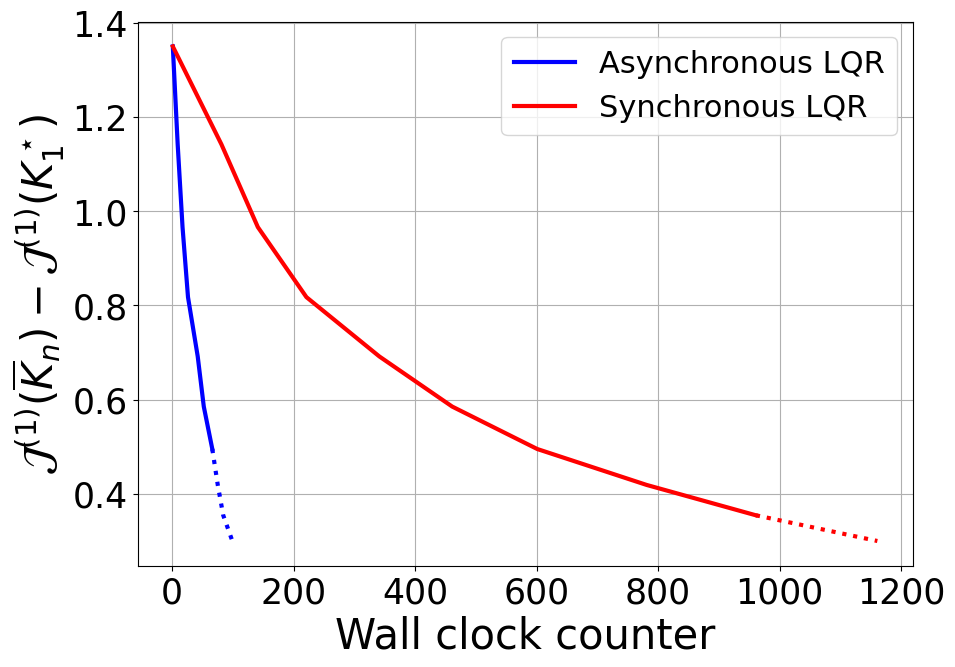

In [100]:
plt.figure(figsize=(10,8))

# Create a plot
plot_1=plt.plot(wall_clock_asyncs[:-3], tolerance_vec[:-3], label="Asynchronous LQR",color='blue', linewidth=3)
plot_2=plt.plot(wall_clock_asyncs[-4:], tolerance_vec[-4:],linestyle='dotted',color='blue', linewidth=3)

plot_3=plt.plot(wall_clock_syncs[:-1], tolerance_vec[:-1], label="Synchronous LQR", color='red',linewidth=3)
plot_4=plt.plot(wall_clock_syncs[-2:], tolerance_vec[-2:], linestyle='dotted',color='red', linewidth=3)

plt.ylabel(r'$\mathcal{J}^{(1)}(\overline{K}_{n})-\mathcal{J}^{(1)}(K^\star_1)$',fontsize=30)
plt.xlabel('Wall clock counter',fontsize=30)
plt.tick_params(axis='both', labelsize=25)
plt.legend(fontsize="22")
# Exclude the shading elements from the legend
plt.subplots_adjust(bottom=0.20)
plt.grid()
plt.savefig('comparison_arxiv.pdf')